In [1]:
import numpy as np 
from pathlib import Path
from src import utils, behavmatch
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 15
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange'] #rew #nrew #rew_test #nrew_test #GI
from IPython.display import clear_output

In [2]:
def get_response_centered(m, nomean=False):
    between_intertrials = np.empty((m.interp_spks.shape[0], m.interp_spks.shape[1], m.interp_spks.shape[2] + 100))
    ## gets the trial, with pre a post intertrial periods
    if nomean:
        interp_spks = m.interp_spks - np.mean(m.interp_spks, axis=1, keepdims=True)
    else:
        interp_spks = m.interp_spks
    for i in range(between_intertrials.shape[1]):
        if i == 0: # just to keep shape consistency this trial is ignored
            intertrial = interp_spks[:, :, 300:400]
            intertrial_mean = np.mean(intertrial, axis=1)
            between_intertrials[:, i, :100] = intertrial_mean # inputting the mean of the intertrial period
            between_intertrials[:, i, 100:] = interp_spks[:, i, :]
        else:
            between_intertrials[:, i, :100] = interp_spks[:, i-1,300:400]
            between_intertrials[:, i, 100:] = interp_spks[:, i, :]
    return between_intertrials

In [3]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
behav_sess = VG11 + VG14 + VG15

In [4]:
mice = []
for sess in behav_sess:
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    mice.append(m)
    clear_output(wait=True)
print("sessions loaded")

sessions loaded


In [5]:
mice

[Mouse(name='VG11', datexp='2024_10_31', blk='2', data_path='Z:/data/PROC'),
 Mouse(name='VG11', datexp='2024_11_14', blk='2', data_path='Z:/data/PROC'),
 Mouse(name='VG14', datexp='2024_11_21', blk='2', data_path='Z:/data/PROC'),
 Mouse(name='VG15', datexp='2024_10_31', blk='2', data_path='Z:/data/PROC')]

In [6]:
midx = 3
neurons, trials, positions = mice[midx].interp_spks.shape
speed, lick_rate, delta_motion, delta_pupil = behavmatch.load_behav_data(mice[midx])
acc = behavmatch.compute_acceleration(speed, ew=.2)
reg_names, covariates = behavmatch.build_covariates(lick_rate, speed, acc, delta_pupil, delta_motion)
category = np.zeros(trials)
category_A = np.concatenate([mice[midx].trial_dict["rewarded"], mice[midx].trial_dict["rewarded test"]])
category[category_A] = 1
print("y: category, X: covariates")

(399, 400, 5) trials, positions, features
y: category, X: covariates


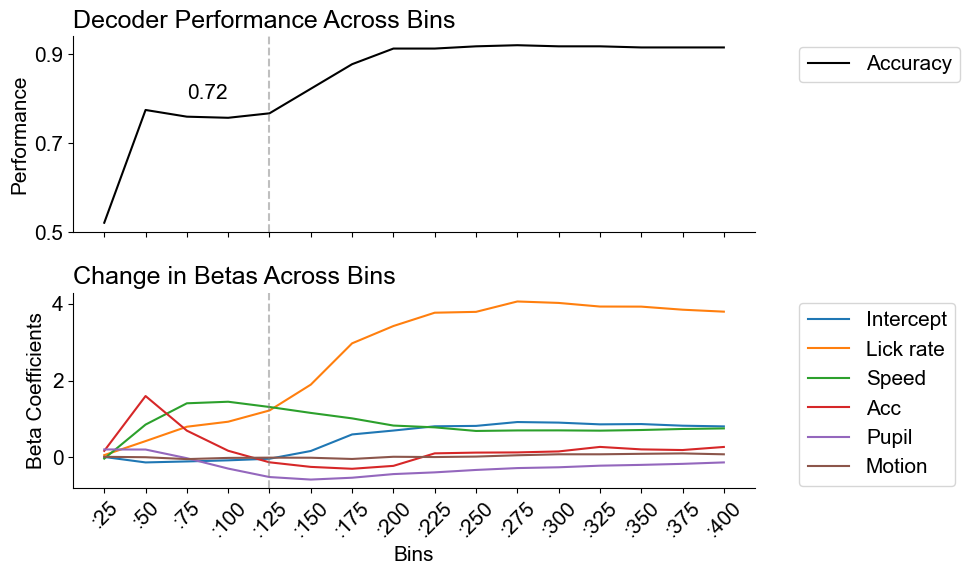

In [7]:
models, prob, betas = behavmatch.reg_cat_frombehav(category, covariates, bin_size=25, n_splits=10, cumulative=True)
auc_scores, accuracies = behavmatch.compute_performance(prob, category)
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
behavmatch.plot_performance_and_betas(auc_scores, accuracies, betas, reg_names, ax, cumulative=True, bin_size=25)

In [8]:
corridor_length = 400
bsize = 25
n_bins = corridor_length // bsize
n_cov = 6
overall_acc = np.zeros((len(mice), n_bins))
overall_betas = np.zeros((len(mice), n_cov, n_bins))
overall_probs = []
for im, m in enumerate(mice):  
    neurons, trials, positions = m.interp_spks.shape
    speed, lick_rate, delta_motion, delta_pupil = behavmatch.load_behav_data(m)
    acc = behavmatch.compute_acceleration(speed, ew=.2)
    reg_names, covariates = behavmatch.build_covariates(lick_rate, speed, acc, delta_pupil, delta_motion)
    category = np.zeros(trials)
    category_A = np.concatenate([m.trial_dict["rewarded"], m.trial_dict["rewarded test"]])
    category[category_A] = 1
    print("y: category, X: covariates")
    models, prob, betas = behavmatch.reg_cat_frombehav(category, covariates, bin_size=bsize, n_splits=10, cumulative=True)
    auc_scores, accuracies = behavmatch.compute_performance(prob, category)
    overall_acc[im] = np.array(accuracies)
    overall_betas[im] = np.array(betas)
    overall_probs.append(prob)
overall_probs = np.array(overall_probs, dtype=object)

(254, 400, 5) trials, positions, features
y: category, X: covariates
(399, 400, 5) trials, positions, features
y: category, X: covariates
(371, 400, 5) trials, positions, features
y: category, X: covariates
(399, 400, 5) trials, positions, features
y: category, X: covariates


## Accuracy across mice

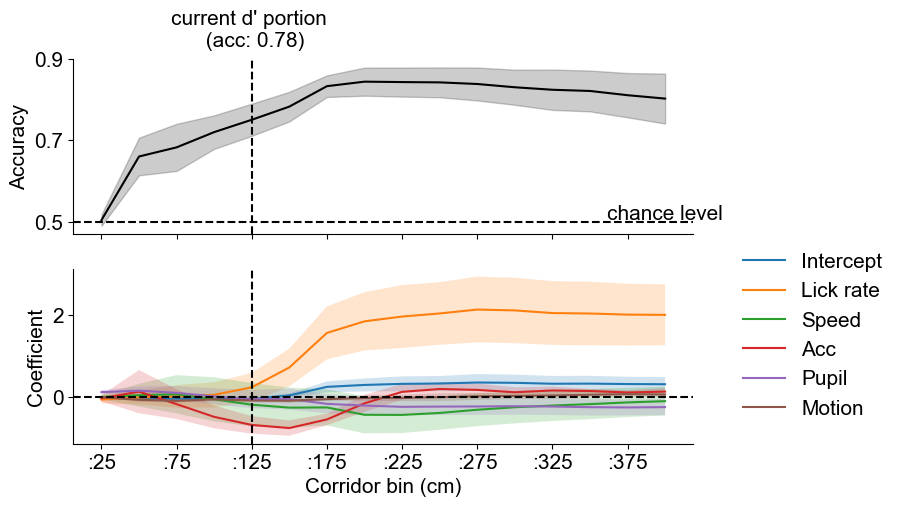

In [9]:
from scipy.stats import sem
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
avg_acc = np.mean(overall_acc, axis=0)
sem_acc = sem(overall_acc, axis=0)
xtickslabels = [f":{int(i*bsize)}" for i in range(1, n_bins+1)]
ax[0].plot(range(1, n_bins+1), avg_acc, color='k')
ax[0].fill_between(range(1, n_bins+1), avg_acc-sem_acc, avg_acc+sem_acc, color='k', alpha=0.2)
ax[0].set_xticks(range(1, n_bins+1, 2))
ax[0].set_xticklabels(xtickslabels[::2]);
ax[0].set_ylabel("Accuracy")
ax[0].set_yticks(np.arange(0.5, 1., 0.2))
ax[0].axvline(5, color='k', linestyle='--')
ax[0].axhline(0.5, color='k', linestyle='--')
ax[0].text(16, 0.52, "chance level", rotation=0, ha='center', va='center', fontsize=default_font);
ymin, ymax = ax[0].get_ylim()
ax[0].text(5, ymax+.07, f"current d' portion \n (acc: {np.round(avg_acc[5],2)})", rotation=0, ha='center', va='center', fontsize=default_font);
avg_b = np.mean(overall_betas, axis=0)
sem_b = sem(overall_betas, axis=0)
xtickslabels = [f":{int(i*bsize)}" for i in range(1, n_bins+1)]
for i in range(n_cov):
    ax[1].plot(range(1, n_bins+1), avg_b[i], label=reg_names[i])
    ax[1].fill_between(range(1, n_bins+1), avg_b[i]-sem_b[i], avg_b[i]+sem_b[i], alpha=0.2)
ax[1].set_xticks(range(1, n_bins+1, 2))
ax[1].set_xticklabels(xtickslabels[::2]);
ax[1].set_ylabel("Coefficient")
ax[1].set_xlabel("Corridor bin (cm)")
ax[1].axvline(5, color='k', linestyle='--')
ax[1].axhline(0, color='k', linestyle='--')
ax[1].legend(loc='upper left', fontsize=default_font, bbox_to_anchor=(1.05, 1.2), frameon=False)

In [10]:
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\overall_acc.npy"), overall_acc)
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\overall_betas.npy"), overall_betas)
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\overall_probs.npy"), overall_probs)

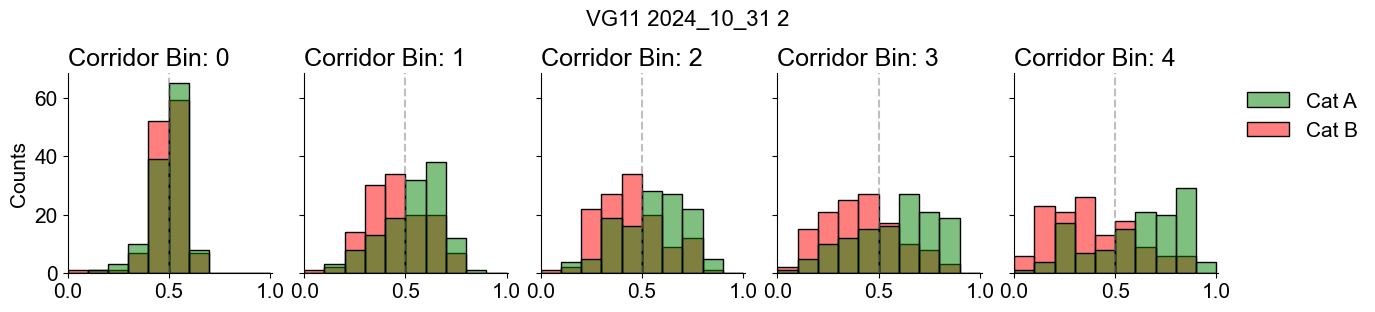

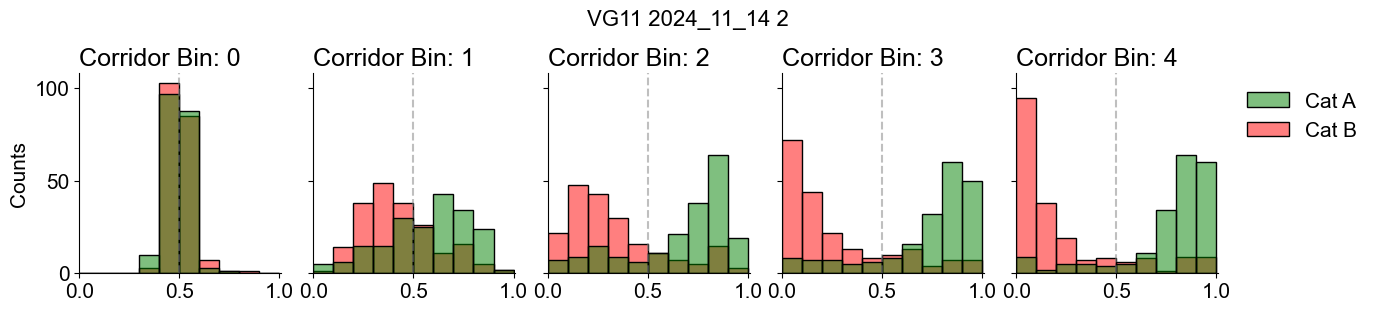

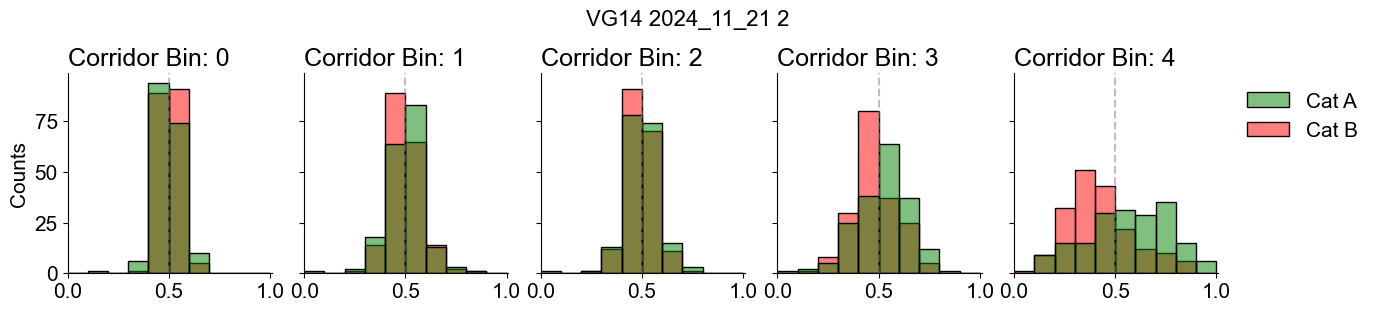

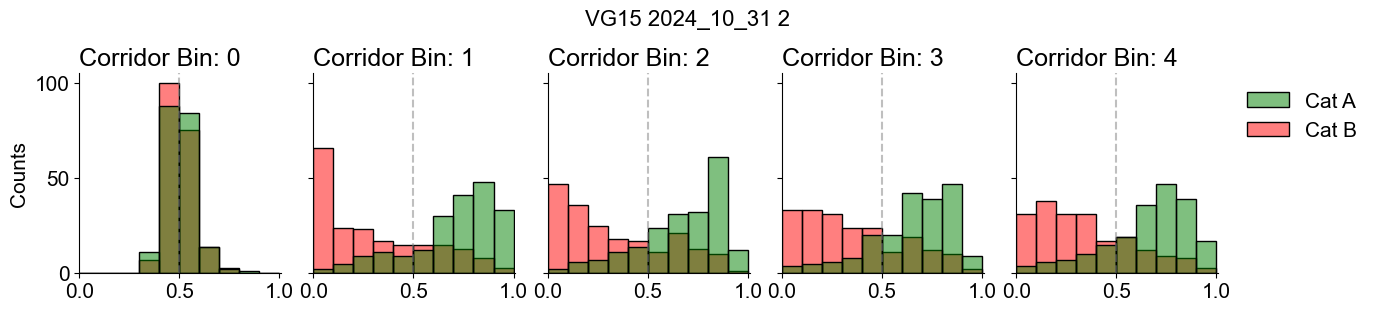

In [11]:
for im, m in enumerate(mice):
    neurons, trials, positions = m.interp_spks.shape
    category = np.zeros(trials)
    category_A = np.concatenate([m.trial_dict["rewarded"], m.trial_dict["rewarded test"]])
    category[category_A] = 1
    behavmatch.plot_prob_bins(overall_probs[im], category)
    plt.suptitle(f"{m.name} {m.datexp} {m.blk}", fontsize=fs_title, y=1.05)


Lets count how many matched trials we have per mouse and bin:

In [12]:
for im, m in enumerate(mice):
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    print(f"{m.name} {m.datexp} {m.blk}")
    prot_matched_trials = behavmatch.match_trials_by_prob_bins(prob, 3, protA, protB, bins=np.linspace(0, 1, 11))
    rest_matched_trials = behavmatch.match_trials_by_prob_bins(prob, 3, restA, restB, bins=np.linspace(0, 1, 11))
    print(f"on bin 3 (0:100): {np.concatenate(prot_matched_trials[:,0]).shape[0]} prototype trials")
    print(f"                  {np.concatenate(rest_matched_trials[:,0]).shape[0]} rest trials")

VG11 2024_10_31 2
on bin 3 (0:100): 23 prototype trials
                  51 rest trials
VG11 2024_11_14 2
on bin 3 (0:100): 41 prototype trials
                  82 rest trials
VG14 2024_11_21 2
on bin 3 (0:100): 35 prototype trials
                  80 rest trials
VG15 2024_10_31 2
on bin 3 (0:100): 20 prototype trials
                  52 rest trials


# lets compute the coding direction on match trials

In [13]:
def dprime_cell(response, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = response[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

def select_neurons(m1, area: str, celltype:str, dprime = None, dptsh=95):
    ia = utils.get_region_idx(m1.iarea, area)
    assert celltype in ['exc', 'inh'], "celltype must be either 'exc' or 'inh'"
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool) if celltype == 'exc' else m1.isred[:,0].astype(bool)
    if dprime is None:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=dptsh) #tresh based on the area
    else:
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dprime[ia*selected_type], tsh=dptsh)
    prefer_r = (m1.train_dp>=pstv_tsh)
    prefer_nr = (m1.train_dp<=ngtv_tsh)
    area_prefer_r = prefer_r * ia * selected_type
    area_prefer_nr = prefer_nr * ia * selected_type
    return area_prefer_r, area_prefer_nr, selected_type, ia

In [14]:
cbin = 3
areas = ["V1", "medial", "lateral", "anterior"]
c_types = ["exc", "inh"]
matched_cds = np.empty((len(mice), 4, len(areas), len(c_types), corridor_length)) # mice, ttype, areas, cell types, positions
for im, m in enumerate(mice):
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    ## Dprime selection trials
    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
    correct, incorrect = utils.build_correct_dicts(m)
    correctA_train = np.intersect1d(correct["rewarded"], m.trial_dict["rewarded"][::2])
    correctB_train = np.intersect1d(correct["non rewarded"], m.trial_dict["non rewarded"][::2])
    dp = dprime_cell(interp_spks, correctA_train, correctB_train, discrimination_region=(0,100))
    prot_matched_trials = behavmatch.match_trials_by_prob_bins(prob, cbin, protA, protB, bins=np.linspace(0, 1, 11), random_state=0)
    rest_matched_trials = behavmatch.match_trials_by_prob_bins(prob, cbin, restA, restB, bins=np.linspace(0, 1, 11), random_state=0)
    m_rew = np.concatenate(prot_matched_trials[:,0]).astype(int)
    m_nrew = np.concatenate(prot_matched_trials[:,1]).astype(int)
    m_rew_test = np.concatenate(rest_matched_trials[:,0]).astype(int)
    m_nrew_test = np.concatenate(rest_matched_trials[:,1]).astype(int)
    matched_dict = {"rewarded": m_rew, "non rewarded": m_nrew, "rewarded test": m_rew_test, "non rewarded test": m_nrew_test}
    for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
        for ct, c_type in enumerate(["exc", "inh"]):
            a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type, dprime=dp)
            cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
            for it, trials in enumerate(matched_dict.values()):
                matched_cds[im, it, ia, ct] = cd[trials,:].mean(0)

In [15]:
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\cod_dirs_0_100_lasttraining_matched.npy"), matched_cds)

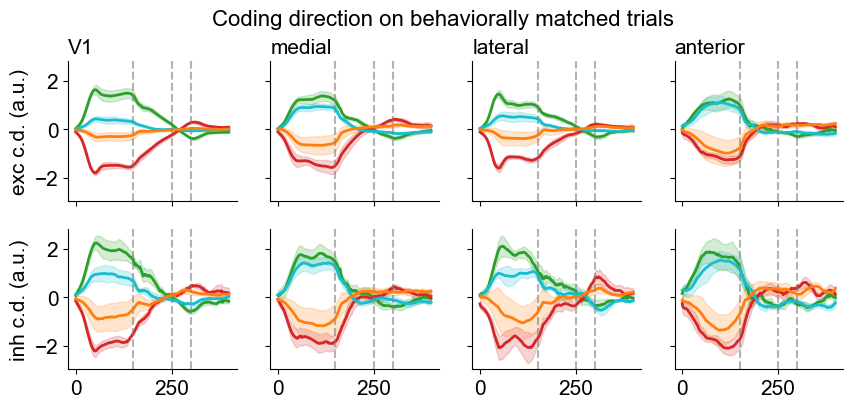

In [16]:
matched_mean = np.mean(matched_cds, axis=0)
matched_sem = sem(matched_cds, axis=0)
fig, ax = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.suptitle(f"Coding direction on behaviorally matched trials", fontsize=fs_title, y=1.01)
for ttype in range(4):
    for a, area in enumerate(areas):
        ax[0, a].set_title(f"{area}", fontsize=default_font)
        for ct, c_type in enumerate(c_types):
            mean_response = matched_mean[ttype, a, ct]
            sem_response = matched_sem[ttype, a, ct]
            ax[ct, a].plot(mean_response, color=trial_type_palette[ttype], linewidth=2)
            ax[ct, a].fill_between(np.arange(400), mean_response - sem_response,
                                        mean_response + sem_response, color=trial_type_palette[ttype], alpha=0.2)
            ax[ct, a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
            ax[ct, a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
            ax[ct, a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
            if a==0:
                ax[ct, a].set_ylabel(f"{c_type} c.d. (a.u.)", fontsize=default_font)
            

In [17]:
non_matched_cds = np.empty((len(mice), 4, len(areas), len(c_types), corridor_length)) # mice, ttype, areas, cell types, positions
for im, m in enumerate(mice):
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    ## Dprime selection trials
    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
    correct, incorrect = utils.build_correct_dicts(m)
    correctA_train = np.intersect1d(correct["rewarded"], m.trial_dict["rewarded"][::2])
    correctB_train = np.intersect1d(correct["non rewarded"], m.trial_dict["non rewarded"][::2])
    dp = dprime_cell(interp_spks, correctA_train, correctB_train, discrimination_region=(0,100))
    nonmatched_dict = {"rewarded": protA, "non rewarded": protB, "rewarded test": restA, "non rewarded test": restB}
    for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
        for ct, c_type in enumerate(["exc", "inh"]):
            a_prefer, b_prefer, _ , _ = select_neurons(m, area, c_type, dprime=dp)
            cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
            for it, trials in enumerate(nonmatched_dict.values()):
                non_matched_cds[im, it, ia, ct] = cd[trials,:].mean(0)

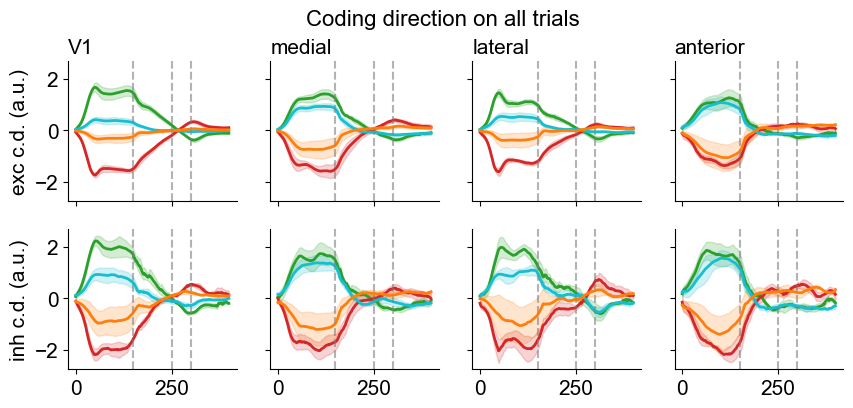

In [18]:
non_matched_mean = np.mean(non_matched_cds, axis=0)
non_matched_sem = sem(non_matched_cds, axis=0)
fig, ax = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.suptitle(f"Coding direction on all trials", fontsize=fs_title, y=1.01)
for ttype in range(4):
    for a, area in enumerate(areas):
        ax[0, a].set_title(f"{area}", fontsize=default_font)
        for ct, c_type in enumerate(c_types):
            mean_response = non_matched_mean[ttype, a, ct]
            sem_response = non_matched_sem[ttype, a, ct]
            ax[ct, a].plot(mean_response, color=trial_type_palette[ttype], linewidth=2)
            ax[ct, a].fill_between(np.arange(400), mean_response - sem_response,
                                        mean_response + sem_response, color=trial_type_palette[ttype], alpha=0.2)
            ax[ct, a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
            ax[ct, a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
            ax[ct, a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
            if a==0:
                ax[ct, a].set_ylabel(f"{c_type} c.d. (a.u.)", fontsize=default_font)

In [19]:
def compute_gi(avgs_coding_dirs, pos):
    """
    Compute the GI for each cell type and area.
    GI = |cyan - orange| / |green - red|

    avgs_coding_dirs: array of shape (mice, ttype, area, cell type, positions)
    """
    gis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    dis = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    gen = np.zeros((avgs_coding_dirs.shape[0], 4, 2))
    avgs_coding_dirs = avgs_coding_dirs[:,:,:,:,:pos].mean(-1) #mouse, ttype, area, cell type, positions
    for area in range(4):
        for cell_type in range(2):
            gen[:, area, cell_type] = avgs_coding_dirs[:,2,area,cell_type] - avgs_coding_dirs[:,3,area,cell_type]
            dis[:, area, cell_type] = avgs_coding_dirs[:,0,area,cell_type] - avgs_coding_dirs[:,1,area,cell_type]
            for m in range(avgs_coding_dirs.shape[0]):
                if (dis[m, area, cell_type] < 0) and (gen[m, area, cell_type] < 0):
                    gis[m, area, cell_type] = np.abs(gen[m, area, cell_type]) / np.abs(dis[m, area, cell_type]) * -1
                else:
                    gis[m, area, cell_type] = gen[m, area, cell_type] / dis[m, area, cell_type]
    return gis, dis, gen

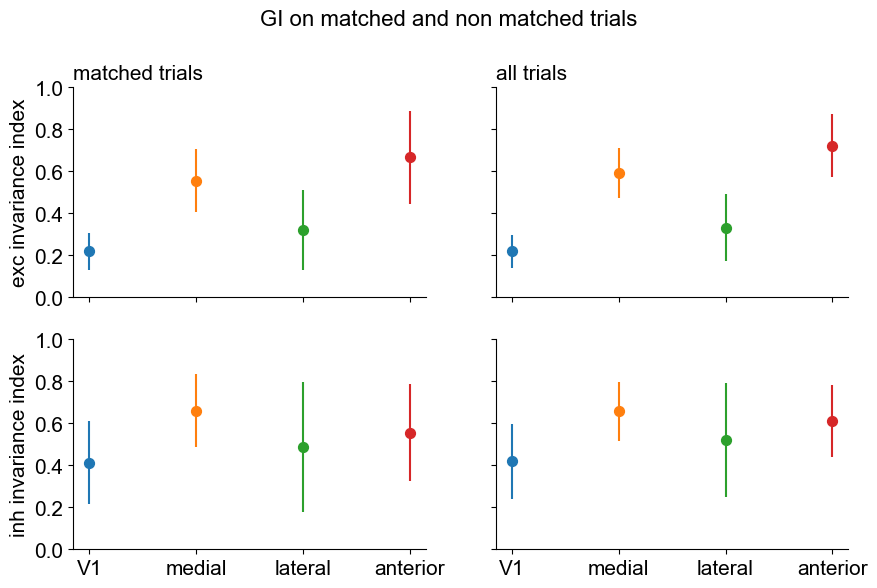

In [20]:
#plot gis for matched and non matched trials
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle(f"GI on matched and non matched trials", fontsize=fs_title, y=1.01)
matched_gi,_,_ = compute_gi(matched_cds, 100)
non_matched_gi,_,_ = compute_gi(non_matched_cds, 100)
ctyps = ["exc", "inh"]
for i, (gi, title) in enumerate(zip([matched_gi, non_matched_gi], ["matched", "all"])):
    for a in range(4):
        for ct, c_type in enumerate(c_types):
            ax[ct,i].errorbar(a, gi[:,a,ct].mean(), yerr=sem(gi[:,a,ct], axis=0))
            ax[ct,i].scatter(a, gi[:,a,ct].mean(), s=50)
            ax[ct,0].set_ylabel(f"{ctyps[ct]} invariance index", fontsize=default_font)
    ax[0,i].set_title(f"{title} trials", fontsize=default_font)
    ax[ct,i].set_xticks(np.arange(4))
    ax[ct,i].set_xticklabels(["V1", "medial", "lateral", "anterior"])
    ax[ct,i].set_ylim(0, 1)

Text(0, 0.5, '$\\Delta$ after controlling')

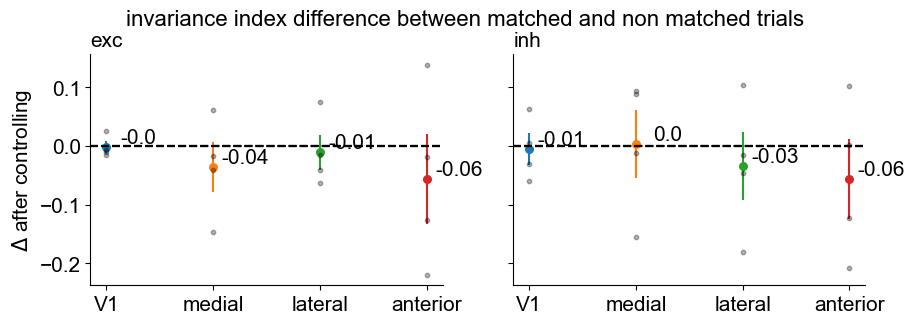

In [21]:
diff = (matched_gi-non_matched_gi)
# plot pct effect
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
fig.suptitle(f"invariance index difference between matched and non matched trials", fontsize=fs_title, y=1.03)
ctyps = ["exc", "inh"]
for a in range(4):
    for ct, c_type in enumerate(c_types):
        ax[ct].errorbar(a, diff[:,a,ct].mean(), yerr=sem(diff[:,a,ct], axis=0))
        ax[ct].scatter(a, diff[:,a,ct].mean(), s=30)
        # add a dot per mouse
        for im in range(len(mice)):
            ax[ct].scatter(a, diff[im,a,ct], s=10, alpha=0.3, color='k', zorder=2)
        ax[ct].set_title(f"{ctyps[ct]}", fontsize=default_font)
        ax[ct].set_xticks(np.arange(4))
        ax[ct].set_xticklabels(["V1", "medial", "lateral", "anterior"]);
        ax[ct].axhline(0, color='k', linestyle='--')
        # add avg on the right of each point
        ax[ct].text(a+.3, diff[:,a,ct].mean(), f"{np.round(diff[:,a,ct].mean(), 2)}", ha='center', va='bottom', fontsize=default_font)
ax[0].set_ylabel("$\Delta$ after controlling", fontsize=default_font)

with the current dprime selection we don't see effect of behavior on gi, so let's check correct vs incorrect trials

In [22]:
correct_incorrect = np.empty((4, 4, 4, 2, 2, 400)) # mice, ttype, areas, cell types, correct/incorrect, positions
for im, m in enumerate(mice):
    print(f"{m.name} {m.datexp} {m.blk}")
    interp_spks = m.interp_spks - m.interp_spks.mean(1, keepdims=True)
    correct, incorrect = utils.build_correct_dicts(m)
    correctA_train = np.intersect1d(correct["rewarded"], m.trial_dict["rewarded"][::2])
    correctB_train = np.intersect1d(correct["non rewarded"], m.trial_dict["non rewarded"][::2])
    dp = dprime_cell(interp_spks, correctA_train, correctB_train, discrimination_region=(0,100))
    correct_crossval = {}
    correct_protA = np.intersect1d(correct["rewarded"], m.trial_dict["rewarded"][1::2])
    correct_protB = np.intersect1d(correct["non rewarded"], m.trial_dict["non rewarded"][1::2])
    correct_crossval["rewarded"] = correct_protA
    correct_crossval["non rewarded"] = correct_protB
    correct_crossval["rewarded test"] = correct["rewarded test"]
    correct_crossval["non rewarded test"] = correct["non rewarded test"]
    for it, ttype in enumerate(["rewarded", "non rewarded", "rewarded test", "non rewarded test"]):
        c_trials = correct_crossval[ttype]
        i_trials = incorrect[ttype]
        print(ttype,": correct trials:", c_trials.shape[0], ", incorrect:", i_trials.shape[0])
        for ia, area in enumerate(["V1", "medial", "lateral", "anterior"]):
            for ct, c_type in enumerate(["exc", "inh"]):
                a_prefer, b_prefer, selected_type, _ = select_neurons(m, area, c_type, dprime=dp)
                cd = interp_spks[a_prefer].mean(0) - interp_spks[b_prefer].mean(0)
                correct_incorrect[im,it,ia,ct, 0] = cd[c_trials,:].mean(0)
                correct_incorrect[im,it,ia,ct, 1] = cd[i_trials,:].mean(0)

VG11 2024_10_31 2
rewarded : correct trials: 25 , incorrect: 12
non rewarded : correct trials: 21 , incorrect: 16
rewarded test : correct trials: 56 , incorrect: 10
non rewarded test : correct trials: 49 , incorrect: 16
VG11 2024_11_14 2
rewarded : correct trials: 49 , incorrect: 2
non rewarded : correct trials: 38 , incorrect: 28
rewarded test : correct trials: 96 , incorrect: 3
non rewarded test : correct trials: 94 , incorrect: 6
VG14 2024_11_21 2
rewarded : correct trials: 43 , incorrect: 4
non rewarded : correct trials: 27 , incorrect: 42
rewarded test : correct trials: 90 , incorrect: 3
non rewarded test : correct trials: 44 , incorrect: 47
VG15 2024_10_31 2
rewarded : correct trials: 44 , incorrect: 9
non rewarded : correct trials: 42 , incorrect: 13
rewarded test : correct trials: 98 , incorrect: 2
non rewarded test : correct trials: 83 , incorrect: 16


In [23]:
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\correct_incorrect_cds.npy"), correct_incorrect)

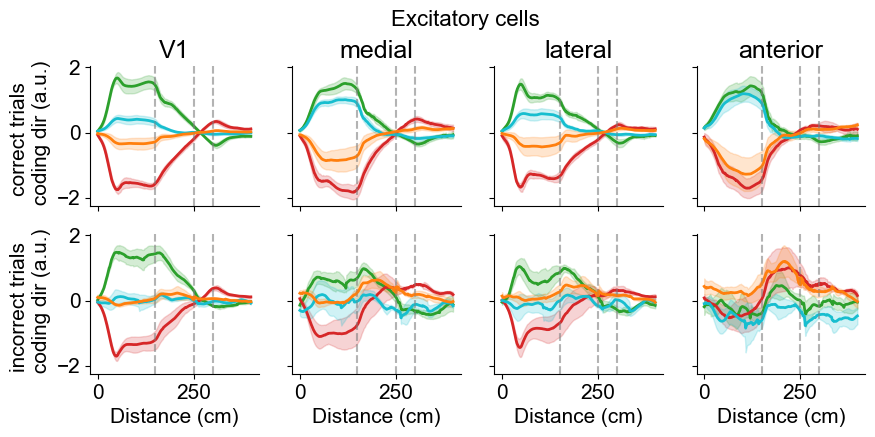

In [24]:
response_exc = correct_incorrect[:,:,:,0,:,:] #excitatory
response_mean = np.mean(response_exc, axis=0)
response_sem = sem(response_exc, axis=0)
fig, ax = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.suptitle('Excitatory cells', fontsize=fs_title, y=1.02)
for ttype in range(4):
    for a, area in enumerate(areas):
        for io, out in enumerate(["correct", "incorrect"]):
            ax[io, a].plot(response_mean[ttype, a, io], color=trial_type_palette[ttype], linewidth=2)
            ax[io, a].fill_between(np.arange(400), response_mean[ttype, a, io] - response_sem[ttype, a, io], 
                                   response_mean[ttype, a, io] + response_sem[ttype, a, io], alpha=0.2, color=trial_type_palette[ttype])
            # plot a line per mouse
            #for im in range(len(mice)):
            #    ax[io, a].plot(response_exc[im, ttype, a, io], alpha=0.3, color=trial_type_palette[ttype])
            ax[io, a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
            ax[io, a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
            ax[io, a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
            if io == 0:
                ax[io, a].set_xlabel('')
                ax[io, a].set_title(f"{areas[a]}", loc='center')
                if a == 0:
                    ax[io, a].set_ylabel('correct trials \n coding dir (a.u.)')
            else:
                ax[io, a].set_xlabel('Distance (cm)')
                if a == 0:
                    ax[io, a].set_ylabel('incorrect trials \n coding dir (a.u.)')

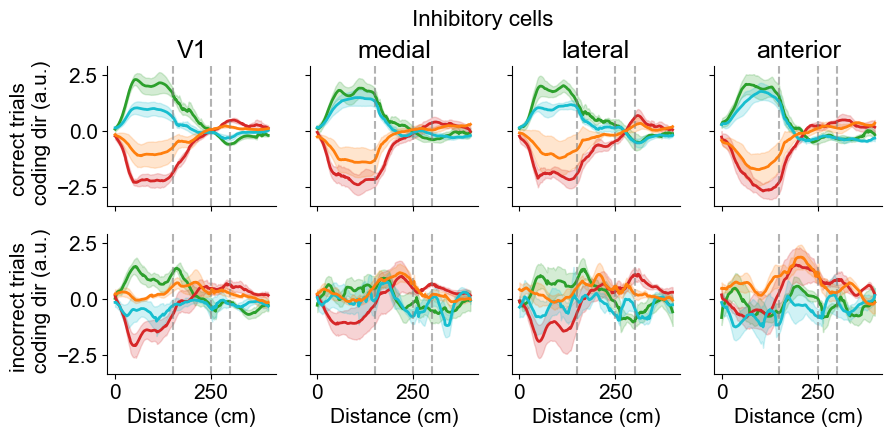

In [25]:
response_inh = correct_incorrect[:,:,:,1,:,:] #inhibitory
response_mean = np.mean(response_inh, axis=0)
response_sem = sem(response_inh, axis=0)
fig, ax = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
fig.suptitle('Inhibitory cells', fontsize=fs_title, y=1.02)
for ttype in range(4):
    for a, area in enumerate(areas):
        for io, out in enumerate(["correct", "incorrect"]):
            ax[io, a].plot(response_mean[ttype, a, io], color=trial_type_palette[ttype], linewidth=2)
            ax[io, a].fill_between(np.arange(400), response_mean[ttype, a, io] - response_sem[ttype, a, io], 
                                   response_mean[ttype, a, io] + response_sem[ttype, a, io], alpha=0.2, color=trial_type_palette[ttype])
            ax[io, a].axvline(x=150, color='gray', linestyle='--', alpha=0.2)
            ax[io, a].axvline(x=250, color='gray', linestyle='--', alpha=0.2)
            ax[io, a].axvline(x=300, color='gray', linestyle='--', alpha=0.2)
            if io == 0:
                ax[io, a].set_xlabel('')
                ax[io, a].set_title(f"{areas[a]}", loc='center')
                if a == 0:
                    ax[io, a].set_ylabel('correct trials \n coding dir (a.u.)')
            else:
                ax[io, a].set_xlabel('Distance (cm)')
                if a == 0:
                    ax[io, a].set_ylabel('incorrect trials \n coding dir (a.u.)')

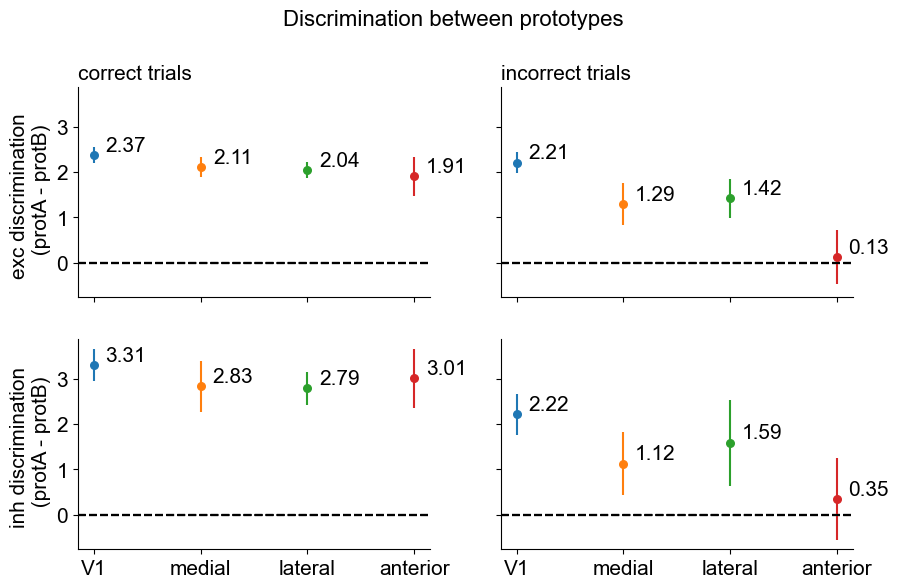

In [26]:
#plot gis for matched and non matched trials
c_response = correct_incorrect[:,:,:,:,0,:]
i_response = correct_incorrect[:,:,:,:,1,:]
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle(f"Discrimination between prototypes", fontsize=fs_title, y=1.01)
c_gi,cdis,cgen = compute_gi(c_response,100)
inc_gi,idis,igen = compute_gi(i_response,100)
ctyps = ["exc", "inh"]
for i, (gi, title) in enumerate(zip([cdis, idis], ["correct", "incorrect"])):
    for a in range(4):
        for ct, c_type in enumerate(c_types):
            ax[ct,i].errorbar(a, gi[:,a,ct].mean(), yerr=sem(gi[:,a,ct], axis=0))
            ax[ct,i].scatter(a, gi[:,a,ct].mean(), s=30)
            ax[ct,0].set_ylabel(f"{ctyps[ct]} discrimination \n (protA - protB)", fontsize=default_font)
            ax[ct,i].axhline(0, color='k', linestyle='--')
    # add avg on the right of each point
            ax[ct,i].text(a+.3, gi[:,a,ct].mean(), f"{np.round(gi[:,a,ct].mean(), 2)}", ha='center', va='bottom', fontsize=default_font)
    ax[0,i].set_title(f"{title} trials", fontsize=default_font)
    ax[ct,i].set_xticks(np.arange(4))
    ax[ct,i].set_xticklabels(["V1", "medial", "lateral", "anterior"])

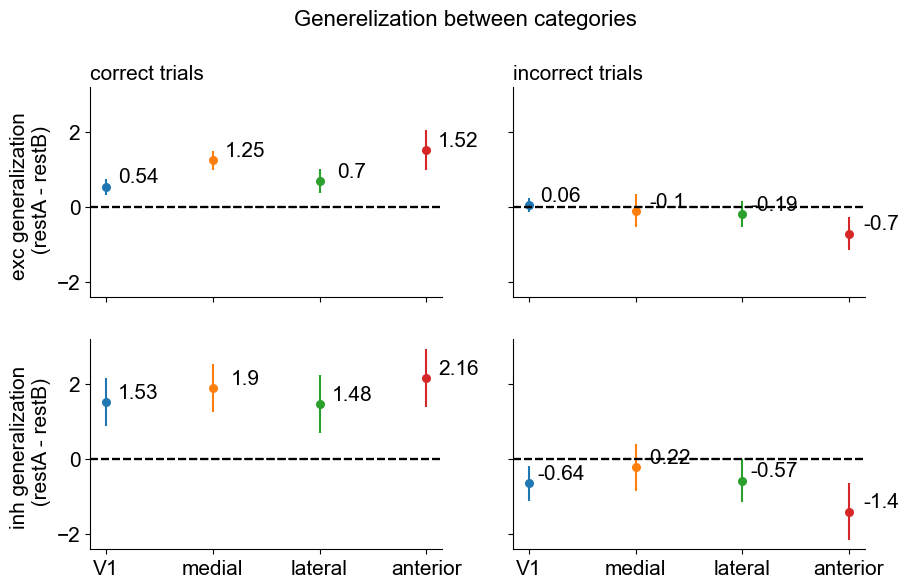

In [27]:
#plot gis for matched and non matched trials
c_response = correct_incorrect[:,:,:,:,0,:]
i_response = correct_incorrect[:,:,:,:,1,:]
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle(f"Generelization between categories", fontsize=fs_title, y=1.01)
c_gi,cdis,cgen = compute_gi(c_response,100)
inc_gi,idis,igen = compute_gi(i_response,100)
ctyps = ["exc", "inh"]
for i, (gi, title) in enumerate(zip([cgen, igen], ["correct", "incorrect"])):
    for a in range(4):
        for ct, c_type in enumerate(c_types):
            ax[ct,i].errorbar(a, gi[:,a,ct].mean(), yerr=sem(gi[:,a,ct], axis=0))
            ax[ct,i].scatter(a, gi[:,a,ct].mean(), s=30)
            ax[ct,0].set_ylabel(f"{ctyps[ct]} generalization \n (restA - restB)", fontsize=default_font)
            ax[ct,i].axhline(0, color='k', linestyle='--')
    # add avg on the right of each point
            ax[ct,i].text(a+.3, gi[:,a,ct].mean(), f"{np.round(gi[:,a,ct].mean(), 2)}", ha='center', va='bottom', fontsize=default_font)
    ax[0,i].set_title(f"{title} trials", fontsize=default_font)
    ax[ct,i].set_xticks(np.arange(4))
    ax[ct,i].set_xticklabels(["V1", "medial", "lateral", "anterior"])


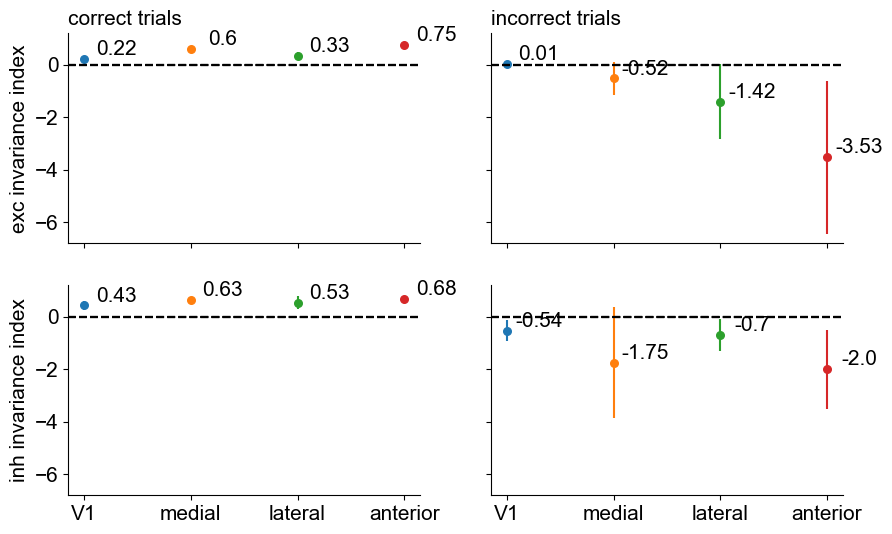

In [28]:
#plot gis for matched and non matched trials
c_response = correct_incorrect[:,:,:,:,0,:]
i_response = correct_incorrect[:,:,:,:,1,:]
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
c_gi,cdis,cgen = compute_gi(c_response,100)
inc_gi,idis,igen = compute_gi(i_response,100)
ctyps = ["exc", "inh"]
for i, (gi, title) in enumerate(zip([c_gi, inc_gi], ["correct", "incorrect"])):
    for a in range(4):
        for ct, c_type in enumerate(c_types):
            ax[ct,i].errorbar(a, gi[:,a,ct].mean(), yerr=sem(gi[:,a,ct], axis=0))
            ax[ct,i].scatter(a, gi[:,a,ct].mean(), s=30)
            ax[ct,0].set_ylabel(f"{ctyps[ct]} invariance index", fontsize=default_font)
            ax[ct,i].axhline(0, color='k', linestyle='--')
    # add avg on the right of each point
            ax[ct,i].text(a+.3, gi[:,a,ct].mean(), f"{np.round(gi[:,a,ct].mean(), 2)}", ha='center', va='bottom', fontsize=default_font)
    ax[0,i].set_title(f"{title} trials", fontsize=default_font)
    ax[ct,i].set_xticks(np.arange(4))
    ax[ct,i].set_xticklabels(["V1", "medial", "lateral", "anterior"])

# lets check behvioral covariates in matched trials

In [29]:
def plot_catvsbehav(behav_cov_catA, behav_cov_catB, ylabel, xlabel, ax, legend=False):
    cat_a = behav_cov_catA
    cat_b = behav_cov_catB
    ax.plot(cat_a.mean(0), color='tab:green', linestyle='-', label='Category A')
    ax.fill_between(np.arange(400), cat_a.mean(0)-sem(cat_a, axis=0), cat_a.mean(0)+sem(cat_a, axis=0), alpha=0.3, color='tab:green')
    ax.plot(cat_b.mean(0), color='tab:red', linestyle='-', label='Category B')
    ax.fill_between(np.arange(400), cat_b.mean(0)-sem(cat_b, axis=0), cat_b.mean(0)+sem(cat_b, axis=0), alpha=0.3, color='tab:red')
    ax.set_ylabel(ylabel)
    ax.set_xticks([0, 150, 250, 300, 400], ['0', '150', '250', '300', '400'], rotation=45)    
    if legend:
        ax.legend(bbox_to_anchor=(1.05, .9), fontsize=default_font, frameon=False)
    if xlabel:
        ax.set_xlabel("Position (cm)")
    #fill between 0 and 100 with gray
    ymin, ymax = ax.get_ylim()
    ax.fill_between(np.arange(100), ymin, ymax, color='gray', alpha=0.2)
    ax.axvline(150, color='k', linestyle='--', alpha=0.3)
    ax.axvline(250, color='k', linestyle='--', alpha=0.3)
    ax.axvline(300, color='k', linestyle='--', alpha=0.3)

In [30]:
matched_feature_means = np.zeros((len(mice), 5, 2, 400)) # mice, features, cat, positions
nonmatched_feature_means = np.zeros((len(mice), 5, 2, 400)) # mice, features, cat, positions
for im, m in enumerate(mice):
    speed, lick_rate, delta_motion, delta_pupil = behavmatch.load_behav_data(m)
    acc = behavmatch.compute_acceleration(speed, ew=.2)
    features = [lick_rate, speed, acc, delta_pupil, delta_motion]
    feature_means = np.zeros((len(features), 2, 400))
    neurons, trials, positions = m.interp_spks.shape
    protA = m.trial_dict["rewarded"][1::2]
    protB = m.trial_dict["non rewarded"][1::2]
    restA = m.trial_dict["rewarded test"]
    restB =  m.trial_dict["non rewarded test"]
    prot_matched_trials = behavmatch.match_trials_by_prob_bins(overall_probs[im], 3, protA, protB, bins=np.linspace(0, 1, 11), random_state=0)
    rest_matched_trials = behavmatch.match_trials_by_prob_bins(overall_probs[im], 3, restA, restB, bins=np.linspace(0, 1, 11), random_state=0)
    catA_prot = np.concatenate(prot_matched_trials[:,0]).astype(int)
    catB_prot = np.concatenate(prot_matched_trials[:,1]).astype(int)
    catA_rest = np.concatenate(rest_matched_trials[:,0]).astype(int)
    catB_rest = np.concatenate(rest_matched_trials[:,1]).astype(int)
    catA_matched = np.concatenate([catA_prot, catA_rest])
    catB_matched = np.concatenate([catB_prot, catB_rest])
    catA_nonmatched = np.concatenate([m.trial_dict["rewarded"], m.trial_dict["rewarded test"]])
    catB_nonmatched = np.concatenate([m.trial_dict["non rewarded"], m.trial_dict["non rewarded test"]])
    for i_f, feature in enumerate(features):
        matched_feature_means[im, i_f, 0] = feature[catA_matched].mean(0)
        matched_feature_means[im, i_f, 1] = feature[catB_matched].mean(0)
        nonmatched_feature_means[im, i_f, 0] = feature[catA_nonmatched].mean(0)
        nonmatched_feature_means[im, i_f, 1] = feature[catB_nonmatched].mean(0)

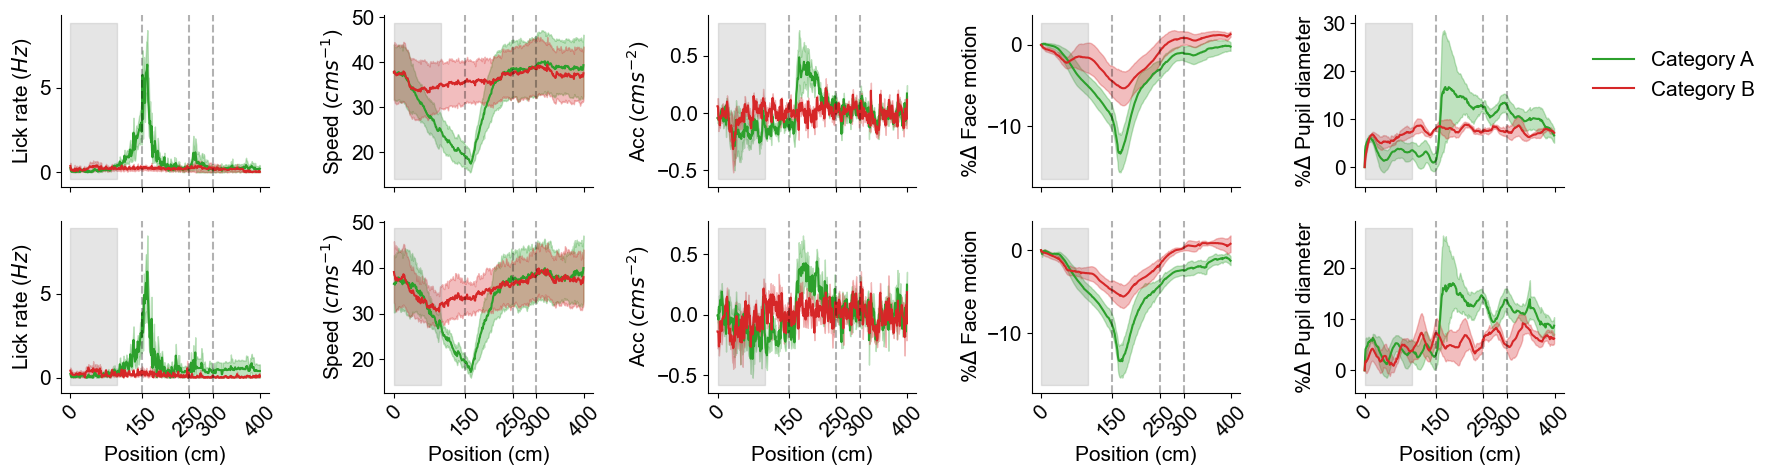

In [31]:
labels = ["Lick rate ($Hz$)", "Speed ($cms^{-1}$)", "Acc ($cm s^{-2}$)", "%$\Delta$ Face motion", "%$\Delta$ Pupil diameter"]
fig, ax = plt.subplots(2, len(features), figsize=(18, 5), sharex=True)
for i_f in range(len(features)):
    if i_f == len(features)-1:
        legend = True
    else:
        legend = False
    plot_catvsbehav(matched_feature_means[:,i_f, 0], matched_feature_means[:,i_f, 1], labels[i_f], True, ax[1, i_f], legend=False)
    plot_catvsbehav(nonmatched_feature_means[:,i_f, 0], nonmatched_feature_means[:,i_f, 1], labels[i_f], False, ax[0, i_f],  legend=legend)
plt.tight_layout()

In [32]:
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\matched_feature_means.npy"), matched_feature_means)
np.save(Path(r"C:\Users\labadmin\Documents\category-neural\data\notz\overall\matchbehav\nonmatched_feature_means.npy"), nonmatched_feature_means)